In [1]:
import os
from rdkit import Chem
from rdkit.Chem import (
    MACCSkeys, 
    GraphDescriptors, 
    Descriptors, 
    rdmolops,
    AllChem,
    rdFingerprintGenerator
)
from rdkit.Chem.rdMolDescriptors import (
    GetHashedAtomPairFingerprint,
    GetHashedTopologicalTorsionFingerprint
)
from rdkit import DataStructs
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors

In [2]:
# 设置 Arial 字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 32  # 设置字体大小

In [21]:
# ===== User Configuration =====
FINGERPRINT_TYPE = "MACCS"  # "MACCS","genWL","graph_embedding"
OUTPUT_DIR = "output"      
WL_ITERATIONS = 3          # 新增参数：控制WL迭代次数
# ==============================

os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_smiles_from_csv(file_path):
    """保持不变"""
    df = pd.read_csv(file_path)
    return df['smiles'].tolist()

# 保持不变
file1 = 'input/dielectric.csv'
file2 = 'new_data/dielectric-moldr.csv'
dataset1 = load_smiles_from_csv(file1)
dataset2 = load_smiles_from_csv(file2)

def safe_mol_from_smiles(smiles):
    """保持不变"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES: {smiles}")
    return mol

mols1 = [mol for mol in [safe_mol_from_smiles(s) for s in dataset1] if mol is not None]
mols2 = [mol for mol in [safe_mol_from_smiles(s) for s in dataset2] if mol is not None]

print(f"\nValid Molecules Statistics:")
print(f"Dataset 1: {len(mols1)}/{len(dataset1)}")
print(f"Dataset 2: {len(mols2)}/{len(dataset2)}")

def calculate_similarity_matrix(fps1, fps2):
    """保持不变"""
    similarity_matrix = []
    for fp1 in fps1:
        row = []
        for fp2 in fps2:
            if FINGERPRINT_TYPE in ["maccs", "pattern", "topological", "atom_pair", "torsion", "morgan"]:
                sim = DataStructs.TanimotoSimilarity(fp1, fp2)
            else:  # 修改：增加genWL的余弦相似度计算
                sim = max(0, min(1, 1 - cosine(fp1, fp2)))
            row.append(sim)
        similarity_matrix.append(row)
    return np.array(similarity_matrix)

# ===== 新增函数：genWL嵌入方法 =====
def genWL_embedding(mol, iterations=WL_ITERATIONS):
    """实现Generalized Weisfeiler-Lehman图嵌入"""
    if mol.GetNumAtoms() == 0:
        return np.zeros(1024)
    
    # 初始标签 = 原子序数
    labels = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()])
    
    # 构建邻接表
    adj = defaultdict(list)
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        adj[i].append(j)
        adj[j].append(i)
    
    # WL迭代
    all_labels = [labels]
    for _ in range(iterations):
        new_labels = []
        for i in range(len(labels)):
            # 聚合邻居标签
            neighbors = sorted([labels[j] for j in adj[i]])
            # 生成新标签（哈希处理）
            new_label = hash(tuple([labels[i]] + neighbors)) % (2**32)
            new_labels.append(new_label)
        labels = np.array(new_labels)
        all_labels.append(labels)
    
    # 生成直方图特征
    hist = np.zeros(1024)
    for labels in all_labels:
        for l in labels:
            idx = l % 1024
            hist[idx] += 1
    
    return hist / hist.sum()  # 归一化




Valid Molecules Statistics:
Dataset 1: 1276/1276
Dataset 2: 500/500


In [22]:
# ===== 特征生成部分 =====
if FINGERPRINT_TYPE == "MACCS":
    print("\nUsing MACCS fingerprints...")
    fps1 = [MACCSkeys.GenMACCSKeys(mol) for mol in mols1]
    fps2 = [MACCSkeys.GenMACCSKeys(mol) for mol in mols2]

elif FINGERPRINT_TYPE == "pattern":
    print("\nUsing substructure pattern fingerprints...")
    fp_gen = rdFingerprintGenerator.GetRDKitFPGenerator()
    fps1 = [fp_gen.GetFingerprint(mol) for mol in mols1]
    fps2 = [fp_gen.GetFingerprint(mol) for mol in mols2]

# ===== 新增genWL选项 =====
elif FINGERPRINT_TYPE == "genWL":
    print(f"\nUsing Generalized Weisfeiler-Lehman (iterations={WL_ITERATIONS})...")
    fps1 = [genWL_embedding(mol) for mol in mols1]
    fps2 = [genWL_embedding(mol) for mol in mols2]

elif FINGERPRINT_TYPE == "topological":
    print("\nUsing topological fingerprints...")
    fps1 = [rdmolops.RDKFingerprint(mol) for mol in mols1]
    fps2 = [rdmolops.RDKFingerprint(mol) for mol in mols2]

elif FINGERPRINT_TYPE == "atom_pair":
    print("\nUsing atom pair fingerprints...")
    fps1 = [GetHashedAtomPairFingerprint(mol) for mol in mols1]
    fps2 = [GetHashedAtomPairFingerprint(mol) for mol in mols2]

elif FINGERPRINT_TYPE == "torsion":
    print("\nUsing topological torsion fingerprints...")
    fps1 = [GetHashedTopologicalTorsionFingerprint(mol) for mol in mols1]
    fps2 = [GetHashedTopologicalTorsionFingerprint(mol) for mol in mols2]

elif FINGERPRINT_TYPE == "morgan":
    print("\nUsing Morgan fingerprints (ECFP)...")
    fps1 = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2) for mol in mols1]
    fps2 = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2) for mol in mols2]
    
elif FINGERPRINT_TYPE == "graph_embedding":
    print("\nUsing graph embedding method...")
    
    def get_graph_descriptors(mol):
        """Get non-negative descriptors"""
        descriptors = [
            abs(GraphDescriptors.BalabanJ(mol)) if mol.GetNumBonds() > 0 else 0,
            abs(GraphDescriptors.BertzCT(mol)),
            Descriptors.MolWt(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.RingCount(mol),
            Descriptors.TPSA(mol),
        ]
        return np.nan_to_num(descriptors, nan=0.0, posinf=1e6, neginf=0)
    
    all_descs = np.vstack([get_graph_descriptors(mol) for mol in mols1 + mols2])
    scaler = MinMaxScaler()
    scaled_descs = scaler.fit_transform(all_descs)
    fps1 = scaled_descs[:len(mols1)]
    fps2 = scaled_descs[len(mols1):]
else:
    raise ValueError(
        "FINGERPRINT_TYPE must be: 'maccs', 'pattern', 'genWL', "  # 更新错误提示
        "'topological', 'atom_pair', 'torsion', 'morgan'"
    )

# 以下保持不变
similarity_matrix = calculate_similarity_matrix(fps1, fps2)

def analyze_similarity(matrix, mols1, mols2):
    """保持不变"""
    avg = np.mean(matrix)
    max_avg1 = np.mean(np.max(matrix, axis=1))
    max_avg2 = np.mean(np.max(matrix, axis=0))
    
    top_matches = []
    for i, row in enumerate(matrix):
        max_idx = np.argmax(row)
        top_matches.append({
            "mol1_idx": i,
            "mol1_smiles": Chem.MolToSmiles(mols1[i]),
            "mol2_idx": max_idx,
            "mol2_smiles": Chem.MolToSmiles(mols2[max_idx]),
            "similarity": row[max_idx]
        })
    
    results_df = pd.DataFrame(top_matches)
    results_df.to_csv(os.path.join(OUTPUT_DIR, "top_matches.csv"), index=False)
    
    return {
        "average_similarity": avg,
        "max_avg_similarity": (max_avg1 + max_avg2) / 2,
        "min_similarity": np.min(matrix),
        "max_similarity": np.max(matrix),
        "similarity_matrix": matrix,
        "top_matches": top_matches
    }

results = analyze_similarity(similarity_matrix, mols1, mols2)

print("\n===== Similarity Analysis Results =====")
print(f"Method: {FINGERPRINT_TYPE}")
print(f"Average similarity: {results['average_similarity']:.4f}")
print(f"Max average similarity: {results['max_avg_similarity']:.4f}")
print(f"Similarity range: [{results['min_similarity']:.4f}, {results['max_similarity']:.4f}]")


print("\n===== Top 5 Highest Similarity Matches =====")
top5 = sorted(results['top_matches'], key=lambda x: x['similarity'], reverse=True)[:5]
for match in top5:
    print(f"Similarity: {match['similarity']:.4f}")
    print(f"Molecule 1 (Idx {match['mol1_idx']}): {match['mol1_smiles']}")
    print(f"Molecule 2 (Idx {match['mol2_idx']}): {match['mol2_smiles']}")
    print("-" * 50)



Using MACCS fingerprints...

===== Similarity Analysis Results =====
Method: MACCS
Average similarity: 0.5482
Max average similarity: 0.8436
Similarity range: [0.0856, 1.0000]

===== Top 5 Highest Similarity Matches =====
Similarity: 1.0000
Molecule 1 (Idx 1048): C=CC1CCC(C=CC2CC(C=Cc3ccccc3)C(F)(F)C2(F)F)C1
Molecule 2 (Idx 22): C=CC1CCC(C=CC2CC(C=Cc3ccccc3)C(F)(F)C2)C1
--------------------------------------------------
Similarity: 1.0000
Molecule 1 (Idx 1062): C=CC1CCC(C=CC2CCC(C=Cc3ccccc3)O2)O1
Molecule 2 (Idx 124): C=CC1CCC(C=CC2CCC(C=Cc3ccccc3)O2)O1
--------------------------------------------------
Similarity: 1.0000
Molecule 1 (Idx 1163): C=CC1CCC(C=CC2CC(C=Cc3ccccc3)C(F)(F)C2)C1
Molecule 2 (Idx 22): C=CC1CCC(C=CC2CC(C=Cc3ccccc3)C(F)(F)C2)C1
--------------------------------------------------
Similarity: 1.0000
Molecule 1 (Idx 1235): C=CC1CC(C=CC2CCC(C=Cc3ccccc3)C2)C(F)(F)C1
Molecule 2 (Idx 22): C=CC1CCC(C=CC2CC(C=Cc3ccccc3)C(F)(F)C2)C1
-------------------------------------------


Similarity plot saved to: output\similarity_distribution_genWL.png


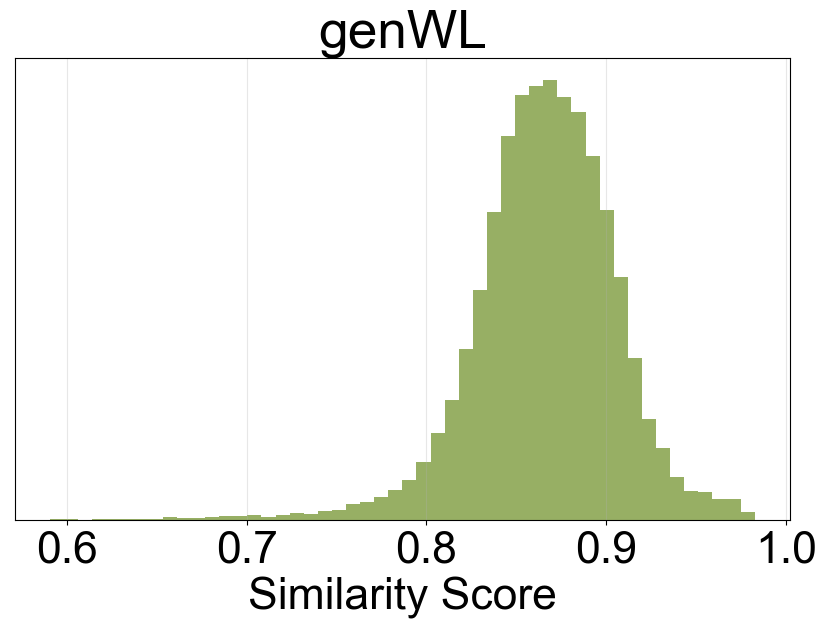

In [20]:
# 选择颜色，这里可以在 'gray', 'darkkhaki', 'olivedrab' 中切换
selected_color = 'olivedrab'
# 原有的绘图代码部分
plt.figure(figsize=(10, 6))
plt.hist(results['similarity_matrix'].flatten(), bins=50, alpha=0.7, color=selected_color)
plt.title(f"{FINGERPRINT_TYPE}")
#plt.title(f"Simple Graph Embeddings")
plt.xlabel("Similarity Score")

# 移除纵坐标刻度
plt.yticks([])

plt.grid(True, alpha=0.3)

# 保存图片
plot_path = os.path.join(OUTPUT_DIR, f"similarity_distribution_{FINGERPRINT_TYPE}.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\nSimilarity plot saved to: {plot_path}")
